In [13]:
!pip install category_encoders
!pip install texthero

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 238 kB 9.9 MB/s 
     |████████████████████████████████| 1.4 MB 7.6 MB/s 
     |████████████████████████████████| 10.4 MB 5.8 MB/s 
     |████████████████████████████████| 366 kB 3.4 MB/s 
     |████████████████████████████████| 24.2 MB 5.4 MB/s 
     |████████████████████████████████| 6.8 MB 11.1 MB/s 
     |████████████████████████████████| 82 kB 2.4 MB/s 
     |████████████████████████████████| 723 kB 15.3 MB/s 
     |████████████████████████████████| 293 kB 2.6 MB/s 
     |████████████████████████████████| 284 kB 3.4 MB/s 
     |████████████████████████████████| 1.1 MB 5.2 MB/s 
     |████████████████████████████████| 9.8 MB 9.9 MB/s 
     |████████████████████████████████| 117 kB 17.9 MB/s 
  Cr

In [1]:
import pandas as pd
import pathlib
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import texthero as hero
from texthero import preprocessing

from sklearn import metrics
from sklearn.model_selection import GroupKFold, KFold

import lightgbm as lgb

from sklearn.metrics import mean_squared_error, mean_squared_log_error

from gensim.models import word2vec

In [2]:
DATA_DIR = pathlib.Path('/home/knikaido/work/atma8/data/')
OUTPUT_DIR = './sub09/'
train_csv_path = DATA_DIR / 'train.csv'
test_csv_path = DATA_DIR / 'test.csv'

In [3]:
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

In [4]:
train_column = train_df.columns

In [5]:
X_column = []
for s in train_column:
    if not'Sales' in s:
        X_column.append(s)

In [6]:
train_df_drop = train_df[X_column]

In [7]:
# User_Scoreの変換
def make_user_score(df):
    d = df['User_Score'].copy()
    d[d == 'tbd'] = 'nan'
    df.loc[:,'User_Score'] = d
    
    return df

In [8]:
train_df_drop = make_user_score(train_df_drop)
test_df = make_user_score(test_df)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [9]:
train_df_drop['Name']

0                             LEGO Batman: The Videogame
1            LEGO Indiana Jones: The Original Adventures
2                             LEGO Batman: The Videogame
3                                                 Combat
4                           LEGO Harry Potter: Years 5-7
                              ...                       
8354                                           Stellaris
8355                   Total War Attila: Tyrants & Kings
8356                    Brothers Conflict: Precious Baby
8357    Phantasy Star Online 2 Episode 4: Deluxe Package
8358    Phantasy Star Online 2 Episode 4: Deluxe Package
Name: Name, Length: 8359, dtype: object

In [10]:
custom_pipeline = [preprocessing.fillna
                   , preprocessing.lowercase
#                    , preprocessing.remove_digits
                   , preprocessing.remove_punctuation
                   , preprocessing.remove_diacritics
                   , preprocessing.remove_whitespace
                  ]
train_df_drop['C_Name'] = hero.clean(train_df_drop['Name'], pipeline=custom_pipeline)
train_df_drop['C_Name']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0                             lego batman the videogame
1            lego indiana jones the original adventures
2                             lego batman the videogame
3                                                combat
4                           lego harry potter years 5 7
                             ...                       
8354                                          stellaris
8355                     total war attila tyrants kings
8356                    brothers conflict precious baby
8357    phantasy star online 2 episode 4 deluxe package
8358    phantasy star online 2 episode 4 deluxe package
Name: C_Name, Length: 8359, dtype: object

In [11]:
train_df_drop['V_Name'] = hero.tfidf(train_df_drop['C_Name'])
train_df_drop['V_Name']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                              ...                        
8354    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
8355    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
8356    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
8357    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
8358    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: V_Name, Length: 8359, dtype: object

In [12]:
sentences = []
for sentence in train_df_drop['C_Name']:
    data = sentence.split()
    sentences.append(data)
#     break

In [13]:
sentences

[['lego', 'batman', 'the', 'videogame'],
 ['lego', 'indiana', 'jones', 'the', 'original', 'adventures'],
 ['lego', 'batman', 'the', 'videogame'],
 ['combat'],
 ['lego', 'harry', 'potter', 'years', '5', '7'],
 ['lego', 'harry', 'potter', 'years', '5', '7'],
 ['yakuza', '4'],
 ['lego', 'harry', 'potter', 'years', '5', '7'],
 ['the', 'lord', 'of', 'the', 'rings', 'war', 'in', 'the', 'north'],
 ['the', 'lord', 'of', 'the', 'rings', 'war', 'in', 'the', 'north'],
 ['the',
  'chronicles',
  'of',
  'narnia',
  'the',
  'lion',
  'the',
  'witch',
  'and',
  'the',
  'wardrobe'],
 ['lego', 'harry', 'potter', 'years', '5', '7'],
 ['the', 'golden', 'compass'],
 ['circus', 'atari'],
 ['maze', 'craze', 'a', 'game', 'of', 'cops', 'n', 'robbers'],
 ['robert', 'ludlum', 's', 'the', 'bourne', 'conspiracy'],
 ['lego', 'harry', 'potter', 'years', '5', '7'],
 ['robert', 'ludlum', 's', 'the', 'bourne', 'conspiracy'],
 ['the', 'golden', 'compass'],
 ['tomb', 'raider', '2013'],
 ['slot', 'machine'],
 ['the'

In [14]:
num_features = 200     # Word vector dimensionality
min_word_count = 20   # Minimum word count
num_workers = 40       # Number of threads to run in parallel
context = 10          # Context window size
downsampling = 1e-3   # Downsample setting for frequent words

print ("Training Word2Vec model...")
# Train Word2Vec model.
# model = Word2Vec(sentences, workers=num_workers, hs = 0, sg = 1, negative = 10, iter = 25,\
#             size=num_features, min_count = min_word_count, \
#             window = context, sample = downsampling, seed=1)

model = word2vec.Word2Vec(sentences,
                          size=200,
                          min_count=1,
                          window=5,
                          iter=20,
                          sg = 0)

model_name = str(num_features) + "features_" + str(min_word_count) + "minwords_" + str(context) + "context_len2alldata"
model.init_sims(replace=True)
# Save Word2Vec model.
print ("Saving Word2Vec model...")
# model.save("../japanese-dataset/livedoor-news-corpus/model/"+model_name)
# endmodeltime = time.time()

# print ("time : ", endmodeltime-start)

Training Word2Vec model...
Saving Word2Vec model...


In [15]:
print(model.wv.index2word[:50])

['the', 'of', '2', 's', 'no', '3', 'super', 'world', 'star', 'ii', 'ds', 'to', 'lego', '4', 'and', 'wars', 'dragon', 'a', 'game', 'disney', 'mario', 'final', 'warriors', 'vs', 'fantasy', 'in', 'nba', 'man', 'heroes', 'collection', 'party', 'force', '5', 'battle', 'quest', 'sonic', 'portable', 'x', 'sales', 'series', 'challenge', 'king', '1', 'war', 'iii', 'dead', 'mega', 'shin', 'legend', 'evil']


In [17]:
model.most_similar(positive=['nintendogs'], topn=20)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).



[('before', 0.995814859867096),
 ('nightmare', 0.995806097984314),
 ('filter', 0.9956463575363159),
 ('horrid', 0.9955952763557434),
 ('travelers', 0.9955874085426331),
 ('cats', 0.9955396056175232),
 ('syphon', 0.9955364465713501),
 ('seuss', 0.995529055595398),
 ('amazing', 0.9955191016197205),
 ('demon', 0.995476484298706),
 ('barbie', 0.9954665303230286),
 ('out', 0.9954457879066467),
 ('aria', 0.9954299926757812),
 ('factory', 0.9954125881195068),
 ('dimension', 0.995402991771698),
 ('nancy', 0.9953797459602356),
 ('bell', 0.9953012466430664),
 ('vampire', 0.995293378829956),
 ('snow', 0.9952694773674011),
 ('krusty', 0.995262861251831)]

In [69]:
w_vec = []
for sentence in train_df_drop['C_Name']:
    data = sentence.split()
    tmp = np.zeros(200)
    for d in data:
        tmp += model[d]
    w_vec.append(tmp)
#     break

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



In [73]:
w_vec = np.array(w_vec)

In [75]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit_transform(w_vec)

array([[-0.45562206, -1.76472946],
       [ 1.56856113, -2.00366984],
       [-0.45562206, -1.76472946],
       ...,
       [ 0.18391141,  0.23438443],
       [ 3.34569037, -0.8297528 ],
       [ 3.34569037, -0.8297528 ]])

In [9]:
# Ratingの変換

In [10]:
def encode_label(train, test):
    cate_col = ['Rating', 'Platform', 'Genre']
    oe = ce.OrdinalEncoder(cols=cate_col, drop_invariant=True, handle_missing='return_nan')
    train.loc[:,cate_col] = oe.fit_transform(train[cate_col])
    test.loc[:,cate_col] = oe.transform(test[cate_col])
    return train, test

In [11]:
train_df_drop, test_df = encode_label(train_df_drop, test_df)

/home/user/.local/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1717: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [12]:
custom_pipeline = [preprocessing.fillna
                   , preprocessing.lowercase
                   , preprocessing.remove_digits
                   , preprocessing.remove_punctuation
                   , preprocessing.remove_diacritics
                   , preprocessing.remove_whitespace
                  ]

In [13]:
def translate_name(df):
    n_pca = hero.pca(hero.tfidf(hero.clean(df['Name'], pipeline=custom_pipeline)))
    n_pca_l = []
    for i in range(len(n_pca)):
        n_pca_l.append(n_pca.values[i])
    n_pca_np = np.array(n_pca_l)
    df['Name_0'] = n_pca_np[:, 0]
    df['Name_1'] = n_pca_np[:, 1]
    
#     n_pca = hero.pca(hero.tfidf(hero.clean(df['Developer'], pipeline=custom_pipeline)))
#     n_pca_l = []
#     for i in range(len(n_pca)):
#         n_pca_l.append(n_pca.values[i])
#     n_pca_np = np.array(n_pca_l)
#     df['Developer_0'] = n_pca_np[:, 0]
#     df['Developer_1'] = n_pca_np[:, 1]
    
#     n_pca = hero.pca(hero.tfidf(hero.clean(df['Publisher'], pipeline=custom_pipeline)))
#     n_pca_l = []
#     for i in range(len(n_pca)):
#         n_pca_l.append(n_pca.values[i])
#     n_pca_np = np.array(n_pca_l)
#     df['Publisher_0'] = n_pca_np[:, 0]
#     df['Publisher_1'] = n_pca_np[:, 1]
    
    return df

In [14]:
train_df_drop = translate_name(train_df_drop)
test_df = translate_name(test_df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [15]:
oof_JP = pd.read_csv('./sub07/oof07JP_Sales.csv')
oof_JP_ = np.expm1(oof_JP['JP_Sales'].values)
oof_NA = pd.read_csv('./sub07/oof07NA_Sales.csv')
oof_NA_ = np.expm1(oof_NA['NA_Sales'].values)
oof_EU = pd.read_csv('./sub07/oof07EU_Sales.csv')
oof_EU_ = np.expm1(oof_EU['EU_Sales'].values)
oof_Other = pd.read_csv('./sub07/oof07Other_Sales.csv')
oof_Other_ = np.expm1(oof_Other['Other_Sales'].values)

train_df_drop['JP_Sales'] = oof_JP_
train_df_drop['NA_Sales'] = oof_NA_
train_df_drop['EU_Sales'] = oof_EU_
train_df_drop['Other_Sales'] = oof_Other_


sub_JP = pd.read_csv('./sub07/sub07JP_Sales.csv')
sub_JP_ = np.expm1(sub_JP['JP_Sales'].values)
sub_NA = pd.read_csv('./sub07/sub07NA_Sales.csv')
sub_NA_ = np.expm1(sub_NA['NA_Sales'].values)
sub_EU = pd.read_csv('./sub07/sub07EU_Sales.csv')
sub_EU_ = np.expm1(sub_EU['EU_Sales'].values)
sub_Other = pd.read_csv('./sub07/sub07Other_Sales.csv')
sub_Other_ = np.expm1(sub_Other['Other_Sales'].values)

test_df['JP_Sales'] = sub_JP_
test_df['NA_Sales'] = sub_NA_
test_df['EU_Sales'] = sub_EU_
test_df['Other_Sales'] = sub_Other_


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [16]:
drop_c = ['Name', 'Publisher', 'Developer']
train_df_drop.drop(drop_c, axis=1, inplace=True)
test_df.drop(drop_c, axis=1, inplace=True)
train_df_drop

,JP_Sales,NA_Sales,EU_Sales,Other_Sales
0,0.195116,110.339205,64.387287,22.467856
1,0.065438,53.191584,35.717341,8.660092
2,-0.281719,73.285979,79.348651,26.845741
3,0.108562,35.232946,2.846780,0.518564
4,0.168898,44.650584,37.649890,8.541944
...,...,...,...,...
8354,-0.419574,-0.219972,7.125007,0.166070
8355,0.054789,0.496931,1.507095,0.052332
8356,1.960770,-0.178722,-0.199779,-0.128329
8357,9.128860,3.310586,1.180593,1.422212


In [17]:
train_df_drop = train_df_drop.astype('float64')
test_df = test_df.astype('float64')

In [18]:
def train(X, y):
    # kfoldの分割数
    k = 5
    kf = KFold(n_splits=k, shuffle=True, random_state=0)
    # kf = GroupKFold(n_splits=k)

    lgbm_params = {'objective': 'regression',
                  "metric":"rmse",
                  "learning_rate": 0.05,
                   'colsample_bytree': 0.8}

    rmsle_train_list = []
    rmsle_eval_list = []

    pred_test_np = np.zeros([k, len(test_df)])
    oof_pred = np.zeros_like(y, dtype=np.float)

    # kfoldで分割
    for i, (train_index, test_index) in enumerate(kf.split(X, y)):

        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]
        y_train = np.log1p(y_train)
        y_test = np.log1p(y_test)

        # データセットを生成する
        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_eval = lgb.Dataset(X_test, y_test)

        # 学習
        model = lgb.train(lgbm_params,
                            lgb_train,
                            valid_sets=[lgb_eval, lgb_train],
                            num_boost_round=10000,
                            early_stopping_rounds=1000,
                            verbose_eval=200)

        predict_train = model.predict(X_train, num_iteration=model.best_iteration)
        predict_eval = model.predict(X_test, num_iteration=model.best_iteration)
        oof_pred[test_index] = predict_eval

        rmsle_train = np.sqrt(mean_squared_error(y_train, predict_train))
        rmsle_eval = np.sqrt(mean_squared_error(y_test, predict_eval))
        print(f'RMSLE_train: {rmsle_train}, RMSLE_eval: {rmsle_eval}')
        rmsle_train_list.append(rmsle_train)
        rmsle_eval_list.append(rmsle_eval)

        pred_test_np[i] = model.predict(test_df, num_iteration=model.best_iteration)

    print(f'RMSLE_train_mean: {np.mean(rmsle_train_list)}, RMSLE_eval_mean: {np.mean(rmsle_eval_list)}')
    
    return oof_pred, pred_test_np, model

In [19]:
sales = 'Global_Sales'
X = train_df_drop
y = train_df[sales].astype('float64')
oof_pred, pred_test_np, model = train(X, y)
print(np.sqrt(mean_squared_error(np.log1p(y), oof_pred)))

Training until validation scores don't improve for 1000 rounds
[200]	training's rmse: 0.83623	valid_0's rmse: 0.946476
[400]	training's rmse: 0.765389	valid_0's rmse: 0.962561
[600]	training's rmse: 0.707396	valid_0's rmse: 0.974604
[800]	training's rmse: 0.659193	valid_0's rmse: 0.988463
[1000]	training's rmse: 0.620728	valid_0's rmse: 0.997823
Early stopping, best iteration is:
[97]	training's rmse: 0.881473	valid_0's rmse: 0.939964
RMSLE_train: 0.8814725055473903, RMSLE_eval: 0.9399643011674181
Training until validation scores don't improve for 1000 rounds
[200]	training's rmse: 0.826674	valid_0's rmse: 0.984267
[400]	training's rmse: 0.755873	valid_0's rmse: 0.997416
[600]	training's rmse: 0.699246	valid_0's rmse: 1.00953
[800]	training's rmse: 0.652299	valid_0's rmse: 1.02154
[1000]	training's rmse: 0.612781	valid_0's rmse: 1.02975
Early stopping, best iteration is:
[69]	training's rmse: 0.89595	valid_0's rmse: 0.974829
RMSLE_train: 0.8959504506238916, RMSLE_eval: 0.97482927959984

In [28]:
oof_df = pd.DataFrame(oof_pred, columns=[sales])
oof_df.to_csv(OUTPUT_DIR + "oof08" + sales + ".csv", index = False)

In [29]:
pred_test_mean = np.mean(pred_test_np, axis=0)
pred_test_exp = np.expm1(pred_test_mean)

In [30]:
sub = pd.read_csv(DATA_DIR / 'atmaCup8_sample-submission.csv')
sub['Global_Sales'] = pred_test_exp
sub.rename(columns={'Global_Sales': sales}, inplace=True)
sub.to_csv(OUTPUT_DIR + "sub08" + sales + ".csv", index = False)

In [33]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    model = models
#     for i, model in enumerate(models):
    _df = pd.DataFrame()
    _df['feature_importance'] = model.feature_importance(importance_type='gain')
    _df['column'] = feat_train_df.columns
#     _df['fold'] = i + 1
    feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
    sns.boxenplot(data=feature_importance_df, x='column', y='feature_importance', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig, ax

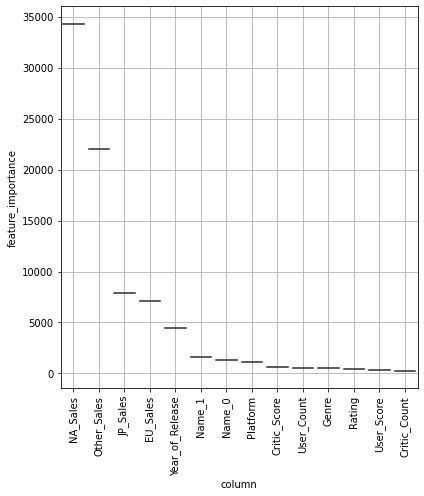

In [34]:
fig, ax = visualize_importance(model, X)


In [25]:
importance = pd.DataFrame(model.feature_importance(importance_type='gain'), index=train_df_drop.columns, columns=['importance'])
importance.sort_values(['importance'])

,importance
Rating,1923.628176
Developer_0,2262.207175
Developer_1,2521.593219
User_Score,3441.732117
Genre,4986.717704
Critic_Score,5141.556932
Critic_Count,7634.363927
Name_0,8909.336788
Name_1,10338.221252
Publisher_1,12838.359179
